In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf

In [2]:
photoswitches = pd.read_csv('./photoswitches.csv')
smiles_list = photoswitches['SMILES'].to_list()

In [3]:
null_columns = photoswitches.columns[photoswitches.isnull().any()]
photoswitches[null_columns].isnull().sum() #two columns completely empty can be removed in raw dataset

rate of thermal isomerisation from Z-E in s-1             330
Solvent used for thermal isomerisation rates              353
Z PhotoStationaryState                                    329
E PhotoStationaryState                                    331
E isomer pi-pi* wavelength in nm                           13
Extinction                                                372
E isomer n-pi* wavelength in nm                           264
Extinction coefficient in M-1 cm-1                        379
Z isomer pi-pi* wavelength in nm                          312
Extinction.1                                              393
Z isomer n-pi* wavelength in nm                           282
Extinction coefficient in M-1 cm-1.1                      382
Wiberg index                                              390
E-Z irradiation wavelength in nm                          341
Z-E irradiation wavelength                                341
Irradiation solvent                                       184
PBE0 DFT

In [4]:
photoswitches.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dropped_data = photoswitches.drop(columns = ['a','BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm','BHLYP/6-31G* Z isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm'])

dropped_data.to_csv ('rawdata_new.csv', index = False)

In [5]:
# split train & predict not in here!!!!
df_new = pd.read_csv('rawdata_new.csv')
df_test = df_new[df_new['E isomer pi-pi* wavelength in nm'].isnull()]
df_train = df_new[df_new['E isomer pi-pi* wavelength in nm'].notnull()]

In [6]:
#smiles_list = photoswitches['SMILES'].to_list()
morganfingerprints = pd.read_csv('./morgan_fingerprints.csv')

In [7]:
morganfingerprints_num = morganfingerprints.drop(morganfingerprints.columns[[0, 1]], axis = 1)
X = morganfingerprints_num
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
reduced_morgfingerprint = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_

array([0.03237782, 0.0251728 ])

In [8]:
df_reduced = pd.DataFrame(reduced_morgfingerprint)

In [9]:
df_joined = pd.merge(df_new, df_reduced, left_index=True, right_index=True)

In [10]:
df_test = df_joined[df_joined['E isomer pi-pi* wavelength in nm'].isnull()]
df_train = df_joined[df_joined['E isomer pi-pi* wavelength in nm'].notnull()]

In [11]:
X_hasvalue = df_train[[0, 1]]
y_hasvalue = df_train['E isomer pi-pi* wavelength in nm']

In [12]:
X_test = df_test[[0, 1]]
y_test= df_test['E isomer pi-pi* wavelength in nm']

In [16]:
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
random_forest = RandomForestRegressor(n_estimators=1000,oob_score = True, max_features = "auto")
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)
#print(accuracy_score(y_test, y_final_pred))

27.919884548104953
[358.41258333 334.12908333 349.09791667 340.98516667 343.27416667
 332.23708333 334.37208333 342.44466667 338.79458333 364.83958333
 362.60558333 348.33858333 327.285     ]


In [32]:
kf = KFold(n_splits=10, shuffle=True, random_state=10)
kf.get_n_splits(X_hasvalue)
for train_index, test_index in kf.split(X_hasvalue):
    X_train, X_test = X_hasvalue.iloc[train_index], X_hasvalue.iloc[test_index]
    y_train, y_test = y_hasvalue.iloc[train_index], y_hasvalue.iloc[test_index]
    rf = RandomForestRegressor(n_estimators=1000)
    rf.fit(X_train, y_train)
score = cross_val_score(rf, X_hasvalue, y_hasvalue, cv = kf)
print(score)
print(score.mean())

[0.63755719 0.66910561 0.60900401 0.51017036 0.43791576 0.47456773
 0.6107214  0.74543052 0.34060769 0.62837697]
0.5663457226458555


In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
bg = BaggingRegressor(base_estimator= RandomForestRegressor(), n_estimators=1000,random_state=0)
bg.fit(X_train, y_train)
y_pred = bg.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = bg.predict(X_test)
print(y_final_pred)

27.960121612636232
[348.43839744 337.71373005 348.11753548 341.07085983 339.91641296
 339.28467096 337.2312291  343.39141197 341.46087675 357.11908332
 354.6759703  345.81671115 328.79505   ]


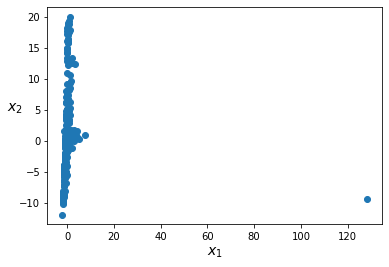

In [15]:
plt.scatter(reduced_morgfingerprint[:, 0], reduced_morgfingerprint[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [32]:
mordred = pd.read_csv('./mordred_descriptors.csv')
mordred_num = mordred.drop(mordred.columns[[0, 1]], axis = 1)
X_1 = mordred_num
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X_1)
pca = PCA(n_components=2)
reduced_mordred = pca.fit_transform(X1_scaled)
pca.explained_variance_ratio_

array([0.29043388, 0.11875416])

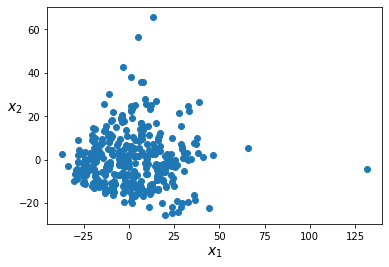

In [33]:
plt.scatter(reduced_mordred[:, 0], reduced_mordred[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [34]:
df_reduced_mordred = pd.DataFrame(reduced_mordred)
df_joined_mordred = pd.merge(df_new, df_reduced_mordred, left_index=True, right_index=True)
df_test_mordred = df_joined_mordred[df_joined_mordred['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_mordred = df_joined_mordred[df_joined_mordred['E isomer pi-pi* wavelength in nm'].notnull()]

In [35]:
X_hasvalue = df_train_mordred[[0, 1]]
y_hasvalue = df_train_mordred['E isomer pi-pi* wavelength in nm']
X_test = df_test_mordred[[0, 1]]
y_test= df_test_mordred['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

31.577568950437318
[368.036 392.59  390.29  414.856 453.954 464.736 457.544 407.964 414.314
 409.76  419.648 376.196 365.414]


In [36]:
raw_data = dropped_data.fillna(0)
photoswitches = pd.read_csv('./rawdata.csv')

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=None)
kf.get_n_splits(X_hasvalue)
for train_index, test_index in kf.split(X_hasvalue):
    X_train, X_test = X_hasvalue.iloc[train_index], X_hasvalue.iloc[test_index]
    y_train, y_test = y_hasvalue.iloc[train_index], y_hasvalue.iloc[test_index]
    rf = RandomForestRegressor(n_estimators=1000)
    rf.fit(X_train, y_train)
score = cross_val_score(rf, X_hasvalue, y_hasvalue, cv = kf)
print(score)
print(score.mean())

In [18]:
#read the clustering csv file
df_kmeans = pd.read_csv('kmeans.csv')
df_kmeans

,Unnamed: 0,SMILES,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,Cluster_PC1_PC2,cluster
0,0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638,-0.114812,-0.236015,0,0
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738,-0.152413,-0.170970,0,0
2,2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0,0
3,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692,0,0
4,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,0.767653,0.595753,1.036594,1.420533,0.004913,-0.525633,0.068216,0.057298,1,1
401,401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,0.388108,-1.573992,1.441147,0.877241,-0.073470,-0.041322,0.034489,-0.151383,0,0
402,402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,3.656931,-0.200196,-0.014167,1.810666,0.157798,-0.054414,0.324967,-0.019254,1,1
403,403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,4.095983,1.083660,0.788775,2.125700,-0.424692,-0.415486,0.363982,0.104224,1,1


In [19]:
#spliting the dataset with clustering
clusters = df_kmeans['cluster']
kp = pd.merge(df_joined, clusters, left_index=True, right_index=True)
#kp
kp_zero = kp[kp['cluster'] == 0] 
kp_one = kp[kp['cluster'] == 1] 

In [20]:
#train on cluster number 0
df_test_zero = kp_zero[kp_zero['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_zero = kp_zero[kp_zero['E isomer pi-pi* wavelength in nm'].notnull()]
kp_zero['E isomer pi-pi* wavelength in nm'].isnull().sum()
X_hasvalue = df_train_zero[[0, 1]]
y_hasvalue = df_train_zero['E isomer pi-pi* wavelength in nm']
X_test = df_test_zero[[0, 1]]
y_test= df_test_zero['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

26.097483050847462
[328.613 329.254 329.905 335.321 357.401 339.562 329.146 331.219 333.928]


In [55]:
#train on cluster number 1
df_test_one = kp_one[kp_one['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_one = kp_one[kp_one['E isomer pi-pi* wavelength in nm'].notnull()]
X_hasvalue = df_train_one[[0, 1]]
y_hasvalue = df_train_one['E isomer pi-pi* wavelength in nm']
X_test = df_test_one[[0, 1]]
y_test= df_test_one['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

37.164625476190466
[380.124 380.988 379.113 380.472]


In [57]:
kp_test_zero = kp[kp['E isomer pi-pi* wavelength in nm'].isnull()]
kp_train_zero = kp[kp['E isomer pi-pi* wavelength in nm'].notnull()]
X_hasvalue = kp_train_zero[['cluster']]
y_hasvalue = kp_train_zero['E isomer pi-pi* wavelength in nm']
X_test = kp_test_zero[['cluster']]
y_test= kp_test_zero['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

42.67561416461552
[357.97023626 357.97023626 357.97023626 357.97023626 357.97023626
 434.84412408 434.84412408 357.97023626 357.97023626 357.97023626
 434.84412408 434.84412408 357.97023626]
